<a href="https://colab.research.google.com/github/martostwo/Deep_Temporal_Transformer_TimeSeries_Forecasting/blob/main/DTT_Automatization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Deep Temporal Transformer


#Import & Dark Mode

Modules Installation

In [ ]:
!pip install yfinance
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.3 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting un

Module import & Dark Mode

In [ ]:
#Module Import:
import pandas as pd;
import numpy as np;
import warnings;
import yfinance as yf;
import ta;
import matplotlib.pyplot as plt;
from matplotlib import cycler;
plt.style.use('seaborn');
warnings.filterwarnings("ignore");

#Dark mode for Graphics:
colors = cycler(
    'color',
    [
    '#669FEE','#66EE91', '#9988DD',
    '#EECC55', '#88BB44', '#FFBBBB'
    ]
);

plt.rc('figure', facecolor = '#313233');
plt.rc('axes', facecolor = "#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor = 'gray');

plt.rc('grid', color='474A4A', linestyle='solid');
plt.rc('xtick', color='gray');
plt.rc('ytick', direction='out', color='gray');
plt.rc('legend', facecolor="#313233", edgecolor="#313233");
plt.rc("text", color="#C9C9C9");
plt.rc('figure', facecolor='#313233');

#Preprocessing & Features

Preprocessing & Feature Engineering Functions (Yahoo Finance)

In [ ]:
def yf_preprocessing(ticker):
  df = yf.download(ticker, start="1990-01-01")
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "date"
  return df

def yf_feature(df):

    #Copiamos el DataFrame para evitar interferencias en los datos:
    df_copy = df.copy()

    #creamos el retorno:
    df_copy["returns"] = df_copy["close"].pct_change(1)

    #price
    #df_copy["op"] = df_copy["open"].shift(1)
    #df_copy["hi"] = df_copy["high"].shift(1)
    #df_copy["lo"] = df_copy["low"].shift(1)
    #df_copy["clo"] = df_copy["close"].shift(1)

    #Volume
    df_copy["vol 15"] = df_copy["volume"].rolling(15).mean().shift(1)
    df_copy["vol 60"] = df_copy["volume"].rolling(60).mean().shift(1)

    #Creamos las SMAs:
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    #Creamos la volatilidad:
    df_copy["MSD 15"] = df_copy["returns"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["returns"].rolling(60).std().shift(1)

    #creamos VWAP:
    vwap = ta.volume.VolumeWeightedAveragePrice(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        volume=df['volume'],
        window=5  # periodo de tiempo para el cálculo del VWAP
    )
    df_copy["vwap"] = vwap.vwap.shift(1)

    #Creamos el RSI:
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)

    return df_copy.dropna();

Transform 2D array to 3D

In [ ]:
def X_3d_RNN(X_s, y_s, lag):

    # Verificación simple de longitudes
    if len(X_s) != len(y_s):
        print("Warnings")

    # Creamos la variable X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Creamos la variable y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train

#Model Automatization

In [ ]:
def DTT(ticker, num_model=None):

  #Feature engineering
  df = yf_preprocessing(ticker);
  df = yf_feature(df);

  #Percentage train set
  split = int(0.85*len(df));
  split_val = int(0.95*len(df));

  #Train set
  x_train = df[['SMA 15','SMA 60','MSD 15','MSD 60','rsi','vwap','vol 15','vol 60']].iloc[:split,:]
  y_train = df[['returns']].iloc[:split,:]

  #Validation set
  x_val = df[['SMA 15','SMA 60','MSD 15','MSD 60','rsi','vwap','vol 15','vol 60']].iloc[split:split_val,:]
  y_val = df[['returns']].iloc[split:split_val,:]

  #Test set
  x_test = df[['SMA 15','SMA 60','MSD 15','MSD 60','rsi','vwap','vol 15','vol 60']].iloc[split_val:,:]
  y_test = df[['returns']].iloc[split_val:,:]

  #Standardization
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()

  #Estandarizamos conjunto de entrenamiento
  x_train_sc = sc.fit_transform(x_train)

  #Estandarizamos conjunto de testing
  x_val_sc = sc.transform(x_val)

  #Estandarizamos conjunto de testing
  x_test_sc = sc.transform(x_test)

  lag = 15
  x_train_3d, y_train_3d = X_3d_RNN(x_train_sc, y_train.values, lag)
  x_val_3d, y_val_3d = X_3d_RNN(x_val_sc, y_val.values, lag)
  x_test_3d, y_test_3d = X_3d_RNN(x_test_sc, y_test.values, lag)

  from tensorflow import keras
  from keras import layers

  #create the transformer_encoder
  def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
      # Normalization and Attention
      x = layers.LayerNormalization(epsilon=1e-6)(inputs)
      x = layers.MultiHeadAttention(
          key_dim=head_size, num_heads=num_heads, dropout=dropout
      )(x, x, x)
      x = layers.Dropout(dropout)(x)
      res = x + inputs

      # Feed Forward Part
      x = layers.LayerNormalization(epsilon=1e-6)(res)
      x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
      x = layers.Dropout(dropout)(x)
      x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
      return x + res

  #The following function is provided to build the model, including the attention layer.
  def build_model(
      input_shape,
      head_size,
      num_heads,
      ff_dim,
      num_transformer_blocks,
      mlp_units,
      dropout=0,
      mlp_dropout=0,
  ):
      inputs = keras.Input(shape=input_shape)
      x = inputs
      x = layers.LSTM(10, return_sequences = True)(x)
      for _ in range(num_transformer_blocks):
          x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

      #x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
      
      x = layers.GRU(100, return_sequences = False)(x)
      x = layers.Dropout(mlp_dropout)(x)
      x = layers.Dense(mlp_units, activation="relu")(x)
      outputs = layers.Dense(1)(x)
      return keras.Model(inputs, outputs)

  #We are now ready to build and train the model.
  input_shape = x_train_3d.shape[1:]

  model = build_model(
      input_shape,
      head_size=16,
      num_heads=1,
      ff_dim=4,
      num_transformer_blocks=1,
      mlp_units=125,
      dropout=0.1,
      mlp_dropout=0.25
      
  )

  model.compile(
      loss="mean_squared_error",
      optimizer=keras.optimizers.Adam()
  )
  #model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=5, \
      restore_best_weights=True)]

  model.fit(
      x_train_3d,
      y_train_3d,
      validation_data = (x_val_3d, y_val_3d),
      epochs=200,
      batch_size=64,
      callbacks=callbacks,
  )

  # Create predictions for the whole dataset
  y_pred_train = np.concatenate((np.zeros([lag,1]), model.predict(x_train_3d)), axis=0)

  y_pred_val = np.concatenate((np.zeros([lag,1]), model.predict(x_val_3d)), axis=0)

  y_pred_test = np.concatenate((np.zeros([lag,1]), model.predict(x_test_3d)), axis=0)

  df["prediction"] = np.concatenate((y_pred_train, y_pred_val, y_pred_test), axis=0)

  #Calculamos la estrategia:
  df["strategy"] = df["returns"]*np.sign(df["prediction"].shift(1))

  if num_model != None:
    
    model.save(f"/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/Models/ModelsDTT3_{ticker}/DTT_{num_model}.h5")
    return df["strategy"].iloc[split:split_val], df["strategy"].iloc[split_val:]

  else:

    return df["strategy"].iloc[split:split_val], df["strategy"].iloc[split_val:]

In [ ]:
#data_path ="/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/EURUSD_Daily_1990.csv"

#Library to estimate the time until the end of the loop
from tqdm import tqdm;

#Empty list to contain the returns
returns_val = [];
returns_test = [];

#Compute the returns during the test and validation periods
for i in tqdm(range(100)):
  val, test = DTT("^GSPC", num_model=i)
  returns_val.append(val)
  returns_test.append(test)
  


  0%|          | 0/100 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 23s 21ms/step - loss: 0.0024 - val_loss: 3.9503e-04
Epoch 2/200
111/111 [==============================] - 2s 14ms/step - loss: 3.7490e-04 - val_loss: 2.6170e-04
Epoch 3/200
111/111 [==============================] - 2s 16ms/step - loss: 2.6685e-04 - val_loss: 2.1955e-04
Epoch 4/200
111/111 [==============================] - 2s 15ms/step - loss: 2.2306e-04 - val_loss: 2.2130e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8922e-04 - val_loss: 2.2254e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7481e-04 - val_loss: 2.1511e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7035e-04 - val_loss: 2.1992e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6453e-04 - val_loss: 2.2172e-04
Epoch 9/200
111/111 [==============================] -

  1%|          | 1/100 [00:57<1:35:18, 57.76s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 12s 49ms/step - loss: 0.0016 - val_loss: 3.3482e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 3.5136e-04 - val_loss: 2.6273e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4602e-04 - val_loss: 2.0858e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9667e-04 - val_loss: 2.0860e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8076e-04 - val_loss: 2.1704e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6958e-04 - val_loss: 2.3048e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6004e-04 - val_loss: 2.1608e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5347e-04 - val_loss: 2.0359e-04
Epoch 9/200
111/111 [==============================] -

  2%|▏         | 2/100 [01:44<1:24:09, 51.53s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
110/110 [==============================] - 9s 28ms/step - loss: 0.0013 - val_loss: 2.7631e-04
Epoch 2/200
110/110 [==============================] - 1s 13ms/step - loss: 3.1095e-04 - val_loss: 2.4208e-04
Epoch 3/200
110/110 [==============================] - 1s 10ms/step - loss: 2.2838e-04 - val_loss: 2.3912e-04
Epoch 4/200
110/110 [==============================] - 1s 10ms/step - loss: 1.9995e-04 - val_loss: 2.1957e-04
Epoch 5/200
110/110 [==============================] - 1s 10ms/step - loss: 1.7456e-04 - val_loss: 2.2596e-04
Epoch 6/200
110/110 [==============================] - 1s 11ms/step - loss: 1.6004e-04 - val_loss: 2.1744e-04
Epoch 7/200
110/110 [==============================] - 1s 10ms/step - loss: 1.5380e-04 - val_loss: 2.0652e-04
Epoch 8/200
110/110 [==============================] - 1s 11ms/step - loss: 1.4207e-04 - val_loss: 2.0581e-04
Epoch 9/200
110/110 [==============================] - 

  3%|▎         | 3/100 [02:33<1:20:54, 50.04s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 20ms/step - loss: 0.0031 - val_loss: 5.2855e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 5.0488e-04 - val_loss: 4.3911e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.4625e-04 - val_loss: 3.7916e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.7212e-04 - val_loss: 2.7273e-04
Epoch 5/200
111/111 [==============================] - 2s 15ms/step - loss: 2.5750e-04 - val_loss: 2.6654e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 2.1741e-04 - val_loss: 2.7182e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8580e-04 - val_loss: 2.8437e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7379e-04 - val_loss: 2.5744e-04
Epoch 9/200
111/111 [==============================] -

  4%|▍         | 4/100 [04:04<1:46:03, 66.29s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 27ms/step - loss: 0.0049 - val_loss: 5.0682e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 5.4106e-04 - val_loss: 3.5311e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.6621e-04 - val_loss: 3.2385e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.8842e-04 - val_loss: 3.8694e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4410e-04 - val_loss: 3.2288e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3934e-04 - val_loss: 2.5882e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1985e-04 - val_loss: 2.4224e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9190e-04 - val_loss: 3.2635e-04
Epoch 9/200
111/111 [==============================] -

  5%|▌         | 5/100 [04:52<1:34:48, 59.88s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
110/110 [==============================] - 9s 20ms/step - loss: 0.0032 - val_loss: 3.0339e-04
Epoch 2/200
110/110 [==============================] - 1s 11ms/step - loss: 5.5788e-04 - val_loss: 3.1026e-04
Epoch 3/200
110/110 [==============================] - 1s 10ms/step - loss: 3.8449e-04 - val_loss: 2.3732e-04
Epoch 4/200
110/110 [==============================] - 1s 10ms/step - loss: 2.8294e-04 - val_loss: 2.2149e-04
Epoch 5/200
110/110 [==============================] - 1s 10ms/step - loss: 2.4492e-04 - val_loss: 2.2326e-04
Epoch 6/200
110/110 [==============================] - 1s 10ms/step - loss: 2.1267e-04 - val_loss: 2.6718e-04
Epoch 7/200
110/110 [==============================] - 1s 13ms/step - loss: 1.9480e-04 - val_loss: 2.1402e-04
Epoch 8/200
110/110 [==============================] - 2s 14ms/step - loss: 1.8564e-04 - val_loss: 2.1321e-04
Epoch 9/200
110/110 [==============================] - 

  6%|▌         | 6/100 [05:43<1:28:47, 56.68s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 21ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 5.8182e-04 - val_loss: 6.0650e-04
Epoch 3/200
111/111 [==============================] - 2s 16ms/step - loss: 3.8818e-04 - val_loss: 4.1727e-04
Epoch 4/200
111/111 [==============================] - 2s 14ms/step - loss: 3.1638e-04 - val_loss: 4.9861e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.5903e-04 - val_loss: 3.2311e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3114e-04 - val_loss: 3.8216e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 2.1150e-04 - val_loss: 3.3986e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9861e-04 - val_loss: 2.7409e-04
Epoch 9/200
111/111 [==============================] - 1s 1

  7%|▋         | 7/100 [07:12<1:44:18, 67.29s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 19ms/step - loss: 0.0044 - val_loss: 7.0533e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 6.2505e-04 - val_loss: 4.1162e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.7433e-04 - val_loss: 2.2383e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.9351e-04 - val_loss: 2.3967e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4783e-04 - val_loss: 2.1787e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0797e-04 - val_loss: 2.0864e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8819e-04 - val_loss: 2.0080e-04
Epoch 8/200
111/111 [==============================] - 2s 17ms/step - loss: 1.8264e-04 - val_loss: 2.0141e-04
Epoch 9/200
111/111 [==============================] -

  8%|▊         | 8/100 [08:03<1:35:03, 61.99s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 8s 18ms/step - loss: 0.0027 - val_loss: 2.4139e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 4.7561e-04 - val_loss: 2.2506e-04
Epoch 3/200
111/111 [==============================] - 2s 17ms/step - loss: 3.0702e-04 - val_loss: 2.2472e-04
Epoch 4/200
111/111 [==============================] - 2s 16ms/step - loss: 2.4971e-04 - val_loss: 2.5318e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.2268e-04 - val_loss: 2.4126e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0458e-04 - val_loss: 2.1344e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7905e-04 - val_loss: 2.4340e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6973e-04 - val_loss: 2.2027e-04
Epoch 9/200
111/111 [==============================] - 

  9%|▉         | 9/100 [08:52<1:27:48, 57.89s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0022 - val_loss: 3.0988e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 3.9560e-04 - val_loss: 3.9806e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.7917e-04 - val_loss: 3.7012e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.2620e-04 - val_loss: 2.2084e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9501e-04 - val_loss: 2.5919e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7841e-04 - val_loss: 2.3690e-04
Epoch 7/200
111/111 [==============================] - 2s 15ms/step - loss: 1.6645e-04 - val_loss: 2.0290e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.5893e-04 - val_loss: 2.3524e-04
Epoch 9/200
111/111 [==============================] -

 10%|█         | 10/100 [09:42<1:23:34, 55.72s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 24ms/step - loss: 0.0041 - val_loss: 5.3206e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 6.0028e-04 - val_loss: 3.3969e-04
Epoch 3/200
111/111 [==============================] - 2s 15ms/step - loss: 4.1221e-04 - val_loss: 2.7658e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 3.0103e-04 - val_loss: 2.7695e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.5312e-04 - val_loss: 2.6816e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3354e-04 - val_loss: 2.6232e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0555e-04 - val_loss: 2.3935e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8588e-04 - val_loss: 2.4666e-04
Epoch 9/200
111/111 [==============================] -

 11%|█         | 11/100 [10:17<1:13:11, 49.35s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0015 - val_loss: 2.7367e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 3.4409e-04 - val_loss: 2.4379e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.5340e-04 - val_loss: 2.6317e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0282e-04 - val_loss: 2.7592e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8266e-04 - val_loss: 2.7570e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7144e-04 - val_loss: 2.5153e-04
Epoch 7/200
13/13 [==============================] - 0s 6ms/step


 12%|█▏        | 12/100 [10:39<1:00:11, 41.04s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 8s 19ms/step - loss: 0.0036 - val_loss: 3.0711e-04
Epoch 2/200
111/111 [==============================] - 2s 14ms/step - loss: 5.5311e-04 - val_loss: 6.0331e-04
Epoch 3/200
111/111 [==============================] - 2s 16ms/step - loss: 3.7756e-04 - val_loss: 3.3895e-04
Epoch 4/200
111/111 [==============================] - 2s 17ms/step - loss: 3.0460e-04 - val_loss: 3.1644e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.4820e-04 - val_loss: 2.4868e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.1746e-04 - val_loss: 2.5239e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 2.1280e-04 - val_loss: 2.6527e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8899e-04 - val_loss: 2.3291e-04
Epoch 9/200
111/111 [==============================] - 

 13%|█▎        | 13/100 [11:29<1:03:11, 43.58s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 19ms/step - loss: 0.0023 - val_loss: 2.4621e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 3.7782e-04 - val_loss: 2.6391e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.6167e-04 - val_loss: 2.4638e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0637e-04 - val_loss: 2.2609e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9192e-04 - val_loss: 2.3191e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7765e-04 - val_loss: 2.2601e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.6117e-04 - val_loss: 2.0643e-04
Epoch 8/200
111/111 [==============================] - 2s 17ms/step - loss: 1.5857e-04 - val_loss: 2.1065e-04
Epoch 9/200
111/111 [==============================] -

 14%|█▍        | 14/100 [12:08<1:00:46, 42.40s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 21ms/step - loss: 0.0020 - val_loss: 2.5768e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 3.8026e-04 - val_loss: 2.6691e-04
Epoch 3/200
111/111 [==============================] - 2s 18ms/step - loss: 2.8056e-04 - val_loss: 2.3527e-04
Epoch 4/200
111/111 [==============================] - 2s 15ms/step - loss: 2.1061e-04 - val_loss: 2.2331e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9223e-04 - val_loss: 2.1946e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8048e-04 - val_loss: 2.4164e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.5993e-04 - val_loss: 2.2051e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.4952e-04 - val_loss: 2.5209e-04
Epoch 9/200
111/111 [==============================] - 

 15%|█▌        | 15/100 [12:42<56:09, 39.64s/it]  

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 26ms/step - loss: 0.0038 - val_loss: 8.2698e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 6.7958e-04 - val_loss: 2.8452e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 4.4788e-04 - val_loss: 2.8445e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 3.4893e-04 - val_loss: 2.6098e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.7139e-04 - val_loss: 2.3414e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4204e-04 - val_loss: 3.2966e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2280e-04 - val_loss: 2.5184e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0971e-04 - val_loss: 2.3749e-04
Epoch 9/200
111/111 [==============================] -

 16%|█▌        | 16/100 [13:09<50:26, 36.03s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 26ms/step - loss: 0.0022 - val_loss: 6.1600e-04
Epoch 2/200
111/111 [==============================] - 2s 15ms/step - loss: 3.9721e-04 - val_loss: 2.6631e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.9666e-04 - val_loss: 2.3245e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2569e-04 - val_loss: 2.6292e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9606e-04 - val_loss: 2.2461e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8470e-04 - val_loss: 2.3176e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7580e-04 - val_loss: 2.3012e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5948e-04 - val_loss: 2.3725e-04
Epoch 9/200
111/111 [==============================] -

 17%|█▋        | 17/100 [13:54<53:21, 38.57s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 24ms/step - loss: 0.0016 - val_loss: 3.2380e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 3.2530e-04 - val_loss: 2.2883e-04
Epoch 3/200
111/111 [==============================] - 2s 15ms/step - loss: 2.4975e-04 - val_loss: 2.9585e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.1418e-04 - val_loss: 2.1428e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8387e-04 - val_loss: 2.5161e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7260e-04 - val_loss: 2.1136e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5790e-04 - val_loss: 2.2081e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5474e-04 - val_loss: 2.0894e-04
Epoch 9/200
111/111 [==============================] - 

 18%|█▊        | 18/100 [14:42<56:37, 41.43s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 19ms/step - loss: 0.0030 - val_loss: 3.9460e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 5.1942e-04 - val_loss: 2.6014e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.2384e-04 - val_loss: 3.0755e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.7939e-04 - val_loss: 2.4514e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.2354e-04 - val_loss: 2.8043e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 1.9818e-04 - val_loss: 2.1990e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.7800e-04 - val_loss: 2.3309e-04
Epoch 8/200
111/111 [==============================] - 2s 15ms/step - loss: 1.6665e-04 - val_loss: 2.1820e-04
Epoch 9/200
111/111 [==============================] -

 19%|█▉        | 19/100 [15:27<57:27, 42.56s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
110/110 [==============================] - 10s 23ms/step - loss: 0.0021 - val_loss: 3.1665e-04
Epoch 2/200
110/110 [==============================] - 1s 11ms/step - loss: 3.5773e-04 - val_loss: 3.0608e-04
Epoch 3/200
110/110 [==============================] - 1s 10ms/step - loss: 2.5736e-04 - val_loss: 2.9086e-04
Epoch 4/200
110/110 [==============================] - 1s 10ms/step - loss: 2.0800e-04 - val_loss: 2.8855e-04
Epoch 5/200
110/110 [==============================] - 1s 10ms/step - loss: 1.8439e-04 - val_loss: 2.8607e-04
Epoch 6/200
110/110 [==============================] - 1s 11ms/step - loss: 1.7772e-04 - val_loss: 2.3469e-04
Epoch 7/200
110/110 [==============================] - 2s 14ms/step - loss: 1.6359e-04 - val_loss: 2.0919e-04
Epoch 8/200
110/110 [==============================] - 1s 13ms/step - loss: 1.5609e-04 - val_loss: 2.7301e-04
Epoch 9/200
110/110 [==============================] -

 20%|██        | 20/100 [15:57<51:29, 38.62s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0017 - val_loss: 3.3908e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 3.4876e-04 - val_loss: 2.2784e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.5139e-04 - val_loss: 2.1191e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.1273e-04 - val_loss: 3.1082e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9452e-04 - val_loss: 2.1633e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8022e-04 - val_loss: 2.1550e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.6986e-04 - val_loss: 2.2214e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.6200e-04 - val_loss: 2.0577e-04
Epoch 9/200
111/111 [==============================] -

 21%|██        | 21/100 [16:27<47:45, 36.27s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
110/110 [==============================] - 10s 18ms/step - loss: 0.0031 - val_loss: 8.2020e-04
Epoch 2/200
110/110 [==============================] - 1s 11ms/step - loss: 4.6779e-04 - val_loss: 2.9294e-04
Epoch 3/200
110/110 [==============================] - 1s 10ms/step - loss: 3.1669e-04 - val_loss: 2.8099e-04
Epoch 4/200
110/110 [==============================] - 1s 10ms/step - loss: 2.6426e-04 - val_loss: 2.4680e-04
Epoch 5/200
110/110 [==============================] - 1s 11ms/step - loss: 2.2112e-04 - val_loss: 2.9856e-04
Epoch 6/200
110/110 [==============================] - 2s 15ms/step - loss: 2.0229e-04 - val_loss: 3.3439e-04
Epoch 7/200
110/110 [==============================] - 2s 15ms/step - loss: 1.8721e-04 - val_loss: 2.5866e-04
Epoch 8/200
110/110 [==============================] - 2s 15ms/step - loss: 1.7232e-04 - val_loss: 2.3538e-04
Epoch 9/200
110/110 [==============================] -

 22%|██▏       | 22/100 [17:18<52:52, 40.67s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 8s 19ms/step - loss: 0.0019 - val_loss: 4.1729e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 3.6632e-04 - val_loss: 2.5576e-04
Epoch 3/200
111/111 [==============================] - 2s 15ms/step - loss: 2.7657e-04 - val_loss: 2.3504e-04
Epoch 4/200
111/111 [==============================] - 2s 15ms/step - loss: 2.2736e-04 - val_loss: 2.4528e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0379e-04 - val_loss: 2.1688e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8400e-04 - val_loss: 2.3256e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6756e-04 - val_loss: 2.2247e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6110e-04 - val_loss: 2.1311e-04
Epoch 9/200
111/111 [==============================] - 

 23%|██▎       | 23/100 [17:56<51:07, 39.84s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0017 - val_loss: 3.7570e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 3.8067e-04 - val_loss: 3.1829e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4302e-04 - val_loss: 2.0676e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0033e-04 - val_loss: 2.0827e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 1.7893e-04 - val_loss: 2.1124e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.6490e-04 - val_loss: 2.3498e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.5557e-04 - val_loss: 2.5054e-04
Epoch 8/200
111/111 [==============================] - 2s 13ms/step - loss: 1.4918e-04 - val_loss: 2.0544e-04
Epoch 9/200
111/111 [==============================] -

 24%|██▍       | 24/100 [18:46<54:13, 42.81s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 24ms/step - loss: 0.0015 - val_loss: 2.5570e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 3.0523e-04 - val_loss: 2.7200e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3532e-04 - val_loss: 2.6459e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0088e-04 - val_loss: 2.4432e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8566e-04 - val_loss: 2.2189e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6930e-04 - val_loss: 2.1563e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7250e-04 - val_loss: 2.4700e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5314e-04 - val_loss: 2.3095e-04
Epoch 9/200
111/111 [==============================] -

 25%|██▌       | 25/100 [20:16<1:11:17, 57.03s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
110/110 [==============================] - 9s 17ms/step - loss: 0.0035 - val_loss: 3.9015e-04
Epoch 2/200
110/110 [==============================] - 1s 10ms/step - loss: 5.6447e-04 - val_loss: 2.8627e-04
Epoch 3/200
110/110 [==============================] - 1s 11ms/step - loss: 3.6916e-04 - val_loss: 2.7898e-04
Epoch 4/200
110/110 [==============================] - 1s 11ms/step - loss: 2.7530e-04 - val_loss: 2.5839e-04
Epoch 5/200
110/110 [==============================] - 1s 11ms/step - loss: 2.2904e-04 - val_loss: 2.4707e-04
Epoch 6/200
110/110 [==============================] - 1s 10ms/step - loss: 1.9646e-04 - val_loss: 2.2048e-04
Epoch 7/200
110/110 [==============================] - 1s 12ms/step - loss: 1.7674e-04 - val_loss: 2.1986e-04
Epoch 8/200
110/110 [==============================] - 2s 14ms/step - loss: 1.6920e-04 - val_loss: 2.1533e-04
Epoch 9/200
110/110 [==============================] - 

 26%|██▌       | 26/100 [21:48<1:23:19, 67.56s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 27ms/step - loss: 0.0036 - val_loss: 3.4764e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 5.2982e-04 - val_loss: 3.1812e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.6971e-04 - val_loss: 2.5377e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.6390e-04 - val_loss: 2.1964e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3629e-04 - val_loss: 2.4372e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0824e-04 - val_loss: 2.2281e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9667e-04 - val_loss: 2.1713e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9317e-04 - val_loss: 2.3636e-04
Epoch 9/200
111/111 [==============================] -

 27%|██▋       | 27/100 [23:18<1:30:29, 74.37s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 26ms/step - loss: 0.0024 - val_loss: 5.8031e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 4.9795e-04 - val_loss: 3.3999e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.1477e-04 - val_loss: 2.3642e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.4872e-04 - val_loss: 4.0172e-04
Epoch 5/200
111/111 [==============================] - 2s 15ms/step - loss: 2.0308e-04 - val_loss: 2.7030e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8625e-04 - val_loss: 2.2564e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.7091e-04 - val_loss: 2.3852e-04
Epoch 8/200
111/111 [==============================] - 2s 14ms/step - loss: 1.6273e-04 - val_loss: 2.4427e-04
Epoch 9/200
111/111 [==============================] -

 28%|██▊       | 28/100 [24:09<1:20:30, 67.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 26ms/step - loss: 0.0020 - val_loss: 5.2564e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 3.6540e-04 - val_loss: 3.2870e-04
Epoch 3/200
111/111 [==============================] - 2s 14ms/step - loss: 2.5890e-04 - val_loss: 3.5379e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.2429e-04 - val_loss: 2.3325e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0156e-04 - val_loss: 2.4007e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8577e-04 - val_loss: 2.6599e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7309e-04 - val_loss: 2.1757e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6020e-04 - val_loss: 2.1282e-04
Epoch 9/200
111/111 [==============================] - 

 29%|██▉       | 29/100 [24:44<1:07:58, 57.44s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 20ms/step - loss: 9.2388e-04 - val_loss: 2.4070e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 2.4704e-04 - val_loss: 2.3275e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0872e-04 - val_loss: 2.1711e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7197e-04 - val_loss: 2.3547e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.5210e-04 - val_loss: 1.9966e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 1.4950e-04 - val_loss: 1.9983e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.4735e-04 - val_loss: 2.0579e-04
Epoch 8/200
111/111 [==============================] - 2s 15ms/step - loss: 1.3887e-04 - val_loss: 2.0228e-04
Epoch 9/200
111/111 [=============================

 30%|███       | 30/100 [25:13<57:23, 49.19s/it]  

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0041 - val_loss: 5.5969e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 5.9115e-04 - val_loss: 2.4208e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.3956e-04 - val_loss: 2.2566e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.8297e-04 - val_loss: 2.5621e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3856e-04 - val_loss: 2.2742e-04
Epoch 6/200
111/111 [==============================] - 2s 15ms/step - loss: 2.1668e-04 - val_loss: 2.2104e-04
Epoch 7/200
111/111 [==============================] - 2s 18ms/step - loss: 1.9618e-04 - val_loss: 2.2283e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.9353e-04 - val_loss: 2.3655e-04
Epoch 9/200
111/111 [==============================] -

 31%|███       | 31/100 [25:42<49:23, 42.95s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 19ms/step - loss: 0.0041 - val_loss: 7.5462e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 5.0292e-04 - val_loss: 3.1553e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.2298e-04 - val_loss: 5.8027e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.5275e-04 - val_loss: 3.2812e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0814e-04 - val_loss: 2.5990e-04
Epoch 6/200
111/111 [==============================] - 2s 14ms/step - loss: 2.0060e-04 - val_loss: 2.4756e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8318e-04 - val_loss: 2.4783e-04
Epoch 8/200
111/111 [==============================] - 2s 17ms/step - loss: 1.6687e-04 - val_loss: 2.2862e-04
Epoch 9/200
111/111 [==============================] -

 32%|███▏      | 32/100 [26:32<51:14, 45.22s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 20ms/step - loss: 0.0031 - val_loss: 3.1776e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.5926e-04 - val_loss: 3.4664e-04
Epoch 3/200
111/111 [==============================] - 2s 17ms/step - loss: 3.1436e-04 - val_loss: 2.1560e-04
Epoch 4/200
111/111 [==============================] - 2s 17ms/step - loss: 2.5944e-04 - val_loss: 2.3792e-04
Epoch 5/200
111/111 [==============================] - 2s 16ms/step - loss: 2.1508e-04 - val_loss: 2.0521e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9547e-04 - val_loss: 2.0914e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7867e-04 - val_loss: 2.0974e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7168e-04 - val_loss: 2.2309e-04
Epoch 9/200
111/111 [==============================] -

 33%|███▎      | 33/100 [27:23<52:14, 46.78s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 22ms/step - loss: 0.0026 - val_loss: 3.2074e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.9401e-04 - val_loss: 3.5516e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.3590e-04 - val_loss: 2.6101e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.5499e-04 - val_loss: 2.7204e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3624e-04 - val_loss: 2.2831e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9340e-04 - val_loss: 2.8169e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7548e-04 - val_loss: 2.3049e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.6256e-04 - val_loss: 2.3149e-04
Epoch 9/200
111/111 [==============================] -

 34%|███▍      | 34/100 [28:11<52:01, 47.29s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0026 - val_loss: 4.1285e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 4.6283e-04 - val_loss: 3.4331e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.0339e-04 - val_loss: 2.5294e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3750e-04 - val_loss: 2.4446e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 2.1200e-04 - val_loss: 2.9470e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8992e-04 - val_loss: 2.7034e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8292e-04 - val_loss: 2.6854e-04
Epoch 8/200
111/111 [==============================] - 2s 14ms/step - loss: 1.6326e-04 - val_loss: 2.3536e-04
Epoch 9/200
111/111 [==============================] -

 35%|███▌      | 35/100 [28:42<45:55, 42.39s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 6.3278e-04 - val_loss: 8.2134e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 4.2618e-04 - val_loss: 5.3291e-04
Epoch 4/200
111/111 [==============================] - 2s 14ms/step - loss: 3.3327e-04 - val_loss: 2.9486e-04
Epoch 5/200
111/111 [==============================] - 2s 16ms/step - loss: 2.8721e-04 - val_loss: 2.4712e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 2.5966e-04 - val_loss: 2.4944e-04
Epoch 7/200
111/111 [==============================] - 2s 14ms/step - loss: 2.2505e-04 - val_loss: 2.5994e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0544e-04 - val_loss: 4.5093e-04
Epoch 9/200
111/111 [==============================] - 1s 

 36%|███▌      | 36/100 [29:12<41:20, 38.76s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 19ms/step - loss: 0.0021 - val_loss: 3.2065e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 3.9167e-04 - val_loss: 2.1110e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.8489e-04 - val_loss: 2.4348e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.6034e-04 - val_loss: 2.2107e-04
Epoch 5/200
111/111 [==============================] - 2s 15ms/step - loss: 2.1000e-04 - val_loss: 2.0505e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8743e-04 - val_loss: 2.0060e-04
Epoch 7/200
111/111 [==============================] - 2s 15ms/step - loss: 1.7256e-04 - val_loss: 2.0457e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5902e-04 - val_loss: 2.1653e-04
Epoch 9/200
111/111 [==============================] - 

 37%|███▋      | 37/100 [29:40<37:06, 35.34s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0048 - val_loss: 8.3466e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 6.4008e-04 - val_loss: 0.0012
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 4.1504e-04 - val_loss: 3.4017e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.9968e-04 - val_loss: 2.5328e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 2.4750e-04 - val_loss: 5.5024e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 2.2457e-04 - val_loss: 2.8622e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 2.0528e-04 - val_loss: 2.5747e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8555e-04 - val_loss: 3.0467e-04
Epoch 9/200
13/13 [==============================] - 0s 4m

 38%|███▊      | 38/100 [30:09<34:43, 33.61s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 26ms/step - loss: 0.0026 - val_loss: 2.9708e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 4.3925e-04 - val_loss: 3.0531e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.9880e-04 - val_loss: 2.7679e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4951e-04 - val_loss: 3.2108e-04
Epoch 5/200
111/111 [==============================] - 2s 15ms/step - loss: 2.2463e-04 - val_loss: 2.9053e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.9625e-04 - val_loss: 2.3252e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8100e-04 - val_loss: 2.3447e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7285e-04 - val_loss: 2.2875e-04
Epoch 9/200
111/111 [==============================] -

 39%|███▉      | 39/100 [30:59<39:09, 38.51s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 22ms/step - loss: 0.0036 - val_loss: 4.4435e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 4.8500e-04 - val_loss: 2.7620e-04
Epoch 3/200
111/111 [==============================] - 2s 17ms/step - loss: 3.3318e-04 - val_loss: 4.6485e-04
Epoch 4/200
111/111 [==============================] - 2s 13ms/step - loss: 2.8154e-04 - val_loss: 3.1038e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3923e-04 - val_loss: 3.0634e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.2819e-04 - val_loss: 3.5670e-04
Epoch 7/200
13/13 [==============================] - 0s 4ms/step


 40%|████      | 40/100 [31:28<35:26, 35.45s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 25ms/step - loss: 0.0015 - val_loss: 2.7238e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 3.1211e-04 - val_loss: 2.4222e-04
Epoch 3/200
111/111 [==============================] - 2s 15ms/step - loss: 2.3041e-04 - val_loss: 2.5072e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9353e-04 - val_loss: 2.2233e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7798e-04 - val_loss: 2.3940e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.6180e-04 - val_loss: 2.2421e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5800e-04 - val_loss: 2.0058e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.4627e-04 - val_loss: 2.3446e-04
Epoch 9/200
111/111 [==============================] -

 41%|████      | 41/100 [32:17<39:01, 39.68s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 27ms/step - loss: 0.0022 - val_loss: 3.5846e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 3.6685e-04 - val_loss: 2.0947e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.5954e-04 - val_loss: 2.1979e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1056e-04 - val_loss: 2.4228e-04
Epoch 5/200
111/111 [==============================] - 2s 15ms/step - loss: 1.9121e-04 - val_loss: 2.2295e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 1.7554e-04 - val_loss: 2.1504e-04
Epoch 7/200
13/13 [==============================] - 0s 4ms/step


 42%|████▏     | 42/100 [32:41<33:46, 34.95s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 24ms/step - loss: 0.0067 - val_loss: 3.7824e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 7.8281e-04 - val_loss: 4.1821e-04
Epoch 3/200
111/111 [==============================] - 2s 14ms/step - loss: 4.6998e-04 - val_loss: 4.9189e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 3.5796e-04 - val_loss: 3.4633e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 3.0590e-04 - val_loss: 2.9125e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.7003e-04 - val_loss: 2.5831e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 2.3846e-04 - val_loss: 2.4750e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1519e-04 - val_loss: 2.3284e-04
Epoch 9/200
111/111 [==============================] - 

 43%|████▎     | 43/100 [33:30<37:03, 39.02s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 19ms/step - loss: 0.0048 - val_loss: 4.2021e-04
Epoch 2/200
111/111 [==============================] - 2s 14ms/step - loss: 6.5142e-04 - val_loss: 2.7335e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 4.3358e-04 - val_loss: 2.4095e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 3.2072e-04 - val_loss: 2.4750e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 2.7999e-04 - val_loss: 2.3201e-04
Epoch 6/200
111/111 [==============================] - 2s 15ms/step - loss: 2.2619e-04 - val_loss: 2.3440e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 2.0276e-04 - val_loss: 2.3513e-04
Epoch 8/200
111/111 [==============================] - 2s 18ms/step - loss: 1.9040e-04 - val_loss: 2.1058e-04
Epoch 9/200
111/111 [==============================] -

 44%|████▍     | 44/100 [35:01<51:02, 54.69s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 27ms/step - loss: 0.0037 - val_loss: 6.5142e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.5545e-04 - val_loss: 4.4635e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.8791e-04 - val_loss: 3.4079e-04
Epoch 4/200
111/111 [==============================] - 2s 15ms/step - loss: 2.2955e-04 - val_loss: 2.6601e-04
Epoch 5/200
111/111 [==============================] - 2s 16ms/step - loss: 2.0106e-04 - val_loss: 2.5402e-04
Epoch 6/200
111/111 [==============================] - 2s 15ms/step - loss: 1.8514e-04 - val_loss: 2.6668e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7107e-04 - val_loss: 2.4732e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6337e-04 - val_loss: 2.5920e-04
Epoch 9/200
111/111 [==============================] -

 45%|████▌     | 45/100 [35:36<44:37, 48.69s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 22ms/step - loss: 0.0040 - val_loss: 4.2736e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 8.5503e-04 - val_loss: 3.4659e-04
Epoch 3/200
111/111 [==============================] - 2s 17ms/step - loss: 4.2530e-04 - val_loss: 3.2986e-04
Epoch 4/200
111/111 [==============================] - 2s 15ms/step - loss: 3.3243e-04 - val_loss: 2.8884e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.6551e-04 - val_loss: 3.4569e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 2.3536e-04 - val_loss: 3.4970e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1311e-04 - val_loss: 2.8228e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9490e-04 - val_loss: 3.5629e-04
Epoch 9/200
111/111 [==============================] - 

 46%|████▌     | 46/100 [36:24<43:42, 48.57s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 12s 25ms/step - loss: 0.0027 - val_loss: 4.6116e-04
Epoch 2/200
111/111 [==============================] - 2s 14ms/step - loss: 4.3079e-04 - val_loss: 4.2199e-04
Epoch 3/200
111/111 [==============================] - 2s 14ms/step - loss: 3.0868e-04 - val_loss: 2.3788e-04
Epoch 4/200
111/111 [==============================] - 2s 14ms/step - loss: 2.3540e-04 - val_loss: 2.0928e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 2.0727e-04 - val_loss: 2.0581e-04
Epoch 6/200
111/111 [==============================] - 2s 14ms/step - loss: 1.8496e-04 - val_loss: 2.1549e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.6803e-04 - val_loss: 2.4776e-04
Epoch 8/200
111/111 [==============================] - 2s 18ms/step - loss: 1.6085e-04 - val_loss: 2.1899e-04
Epoch 9/200
111/111 [==============================] -

 47%|████▋     | 47/100 [36:54<38:03, 43.08s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 36ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 6.5957e-04 - val_loss: 3.0086e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.6507e-04 - val_loss: 2.5221e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.8650e-04 - val_loss: 2.7812e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4117e-04 - val_loss: 2.4965e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1187e-04 - val_loss: 2.4981e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9804e-04 - val_loss: 2.2536e-04
Epoch 8/200
111/111 [==============================] - 2s 14ms/step - loss: 1.7857e-04 - val_loss: 2.5580e-04
Epoch 9/200
111/111 [==============================] - 2s 

 48%|████▊     | 48/100 [37:40<38:04, 43.94s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 25ms/step - loss: 0.0033 - val_loss: 2.8996e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 5.0412e-04 - val_loss: 3.0606e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.2948e-04 - val_loss: 3.5188e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.5413e-04 - val_loss: 7.1485e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 4.1778e-04 - val_loss: 2.3075e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0593e-04 - val_loss: 2.2245e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8475e-04 - val_loss: 2.2672e-04
Epoch 8/200
111/111 [==============================] - 2s 15ms/step - loss: 1.7135e-04 - val_loss: 2.1107e-04
Epoch 9/200
111/111 [==============================] -

 49%|████▉     | 49/100 [38:18<35:48, 42.13s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 20ms/step - loss: 0.0038 - val_loss: 3.8058e-04
Epoch 2/200
111/111 [==============================] - 2s 15ms/step - loss: 5.3853e-04 - val_loss: 3.9217e-04
Epoch 3/200
111/111 [==============================] - 2s 17ms/step - loss: 3.5991e-04 - val_loss: 4.0947e-04
Epoch 4/200
111/111 [==============================] - 2s 17ms/step - loss: 3.2193e-04 - val_loss: 2.8830e-04
Epoch 5/200
111/111 [==============================] - 2s 15ms/step - loss: 2.4439e-04 - val_loss: 3.0065e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0990e-04 - val_loss: 2.7607e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9232e-04 - val_loss: 2.6240e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8443e-04 - val_loss: 2.5841e-04
Epoch 9/200
111/111 [==============================] -

 50%|█████     | 50/100 [39:49<47:24, 56.88s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 36ms/step - loss: 0.0036 - val_loss: 4.3566e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 5.2377e-04 - val_loss: 2.4294e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.8223e-04 - val_loss: 2.4501e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.9071e-04 - val_loss: 2.3057e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 2.4297e-04 - val_loss: 2.2838e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2640e-04 - val_loss: 2.2488e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0020e-04 - val_loss: 2.2049e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8721e-04 - val_loss: 2.2240e-04
Epoch 9/200
111/111 [==============================] -

 51%|█████     | 51/100 [41:19<54:23, 66.61s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 20ms/step - loss: 0.0047 - val_loss: 2.8145e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 6.7007e-04 - val_loss: 3.3872e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 4.1737e-04 - val_loss: 4.2631e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 3.2030e-04 - val_loss: 2.7642e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.7559e-04 - val_loss: 2.3365e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 2.3680e-04 - val_loss: 2.4289e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 2.1181e-04 - val_loss: 2.0438e-04
Epoch 8/200
111/111 [==============================] - 2s 15ms/step - loss: 1.9204e-04 - val_loss: 2.0699e-04
Epoch 9/200
111/111 [==============================] -

 52%|█████▏    | 52/100 [42:15<50:51, 63.57s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 12s 21ms/step - loss: 0.0029 - val_loss: 3.7137e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 4.6942e-04 - val_loss: 2.3440e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.0917e-04 - val_loss: 2.2943e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.4037e-04 - val_loss: 2.5091e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0368e-04 - val_loss: 4.8011e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1051e-04 - val_loss: 4.5081e-04
Epoch 7/200
111/111 [==============================] - 2s 14ms/step - loss: 2.3293e-04 - val_loss: 2.3153e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.7338e-04 - val_loss: 2.2207e-04
Epoch 9/200
111/111 [==============================] -

 53%|█████▎    | 53/100 [42:58<44:57, 57.39s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 23ms/step - loss: 0.0043 - val_loss: 2.7208e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 6.3352e-04 - val_loss: 2.5751e-04
Epoch 3/200
111/111 [==============================] - 2s 16ms/step - loss: 3.9847e-04 - val_loss: 2.2917e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 3.0837e-04 - val_loss: 2.2444e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.5319e-04 - val_loss: 2.1262e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.2175e-04 - val_loss: 2.1851e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0990e-04 - val_loss: 2.0669e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9505e-04 - val_loss: 2.2909e-04
Epoch 9/200
111/111 [==============================] - 

 54%|█████▍    | 54/100 [43:47<41:56, 54.71s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 12s 21ms/step - loss: 0.0037 - val_loss: 4.2309e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 5.3062e-04 - val_loss: 2.7703e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.4396e-04 - val_loss: 2.7073e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.8012e-04 - val_loss: 3.0301e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.3604e-04 - val_loss: 2.5198e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0335e-04 - val_loss: 2.1125e-04
Epoch 7/200
111/111 [==============================] - 2s 15ms/step - loss: 1.9516e-04 - val_loss: 2.1425e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8558e-04 - val_loss: 2.2420e-04
Epoch 9/200
111/111 [==============================] -

 55%|█████▌    | 55/100 [45:01<45:30, 60.68s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 27ms/step - loss: 0.0017 - val_loss: 3.1722e-04
Epoch 2/200
111/111 [==============================] - 2s 13ms/step - loss: 3.2362e-04 - val_loss: 3.7018e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3523e-04 - val_loss: 2.5947e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0928e-04 - val_loss: 2.2694e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8317e-04 - val_loss: 2.1716e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6976e-04 - val_loss: 2.1243e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5752e-04 - val_loss: 2.0174e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5509e-04 - val_loss: 2.2951e-04
Epoch 9/200
111/111 [==============================] -

 56%|█████▌    | 56/100 [45:51<42:05, 57.39s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0015 - val_loss: 4.8749e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 3.3230e-04 - val_loss: 2.7127e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4385e-04 - val_loss: 2.9060e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0149e-04 - val_loss: 3.3430e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8129e-04 - val_loss: 2.4506e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.6647e-04 - val_loss: 2.6958e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.5978e-04 - val_loss: 2.7062e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.5342e-04 - val_loss: 2.3614e-04
Epoch 9/200
111/111 [==============================] -

 57%|█████▋    | 57/100 [46:38<38:57, 54.35s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 19ms/step - loss: 0.0012 - val_loss: 2.5264e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 3.0216e-04 - val_loss: 2.6274e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1576e-04 - val_loss: 2.2009e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8212e-04 - val_loss: 2.2584e-04
Epoch 5/200
111/111 [==============================] - 2s 17ms/step - loss: 2.0891e-04 - val_loss: 2.0306e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 1.6228e-04 - val_loss: 2.0181e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.4853e-04 - val_loss: 2.0272e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.4673e-04 - val_loss: 2.0097e-04
Epoch 9/200
111/111 [==============================] -

 58%|█████▊    | 58/100 [47:19<35:14, 50.35s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 12s 22ms/step - loss: 0.0022 - val_loss: 5.1256e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 3.8071e-04 - val_loss: 2.9562e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.5279e-04 - val_loss: 2.4757e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2628e-04 - val_loss: 2.8863e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9323e-04 - val_loss: 2.1884e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7766e-04 - val_loss: 2.1734e-04
Epoch 7/200
111/111 [==============================] - 2s 14ms/step - loss: 1.6442e-04 - val_loss: 2.1519e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.5511e-04 - val_loss: 2.5625e-04
Epoch 9/200
111/111 [==============================] -

 59%|█████▉    | 59/100 [48:09<34:18, 50.20s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 18ms/step - loss: 0.0041 - val_loss: 9.0516e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 5.6494e-04 - val_loss: 3.8785e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.5537e-04 - val_loss: 3.8793e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.8151e-04 - val_loss: 3.5568e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.3441e-04 - val_loss: 3.3974e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 2.2064e-04 - val_loss: 2.5444e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.9075e-04 - val_loss: 2.6137e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8063e-04 - val_loss: 2.4149e-04
Epoch 9/200
111/111 [==============================] -

 60%|██████    | 60/100 [48:56<32:45, 49.13s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 20ms/step - loss: 0.0037 - val_loss: 8.8097e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.8520e-04 - val_loss: 2.9720e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.1998e-04 - val_loss: 2.6844e-04
Epoch 4/200
111/111 [==============================] - 2s 16ms/step - loss: 2.5663e-04 - val_loss: 2.3145e-04
Epoch 5/200
111/111 [==============================] - 2s 16ms/step - loss: 2.2669e-04 - val_loss: 2.3445e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 2.0996e-04 - val_loss: 2.3836e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8535e-04 - val_loss: 2.1074e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7293e-04 - val_loss: 2.2100e-04
Epoch 9/200
111/111 [==============================] -

 61%|██████    | 61/100 [49:46<32:11, 49.53s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 27ms/step - loss: 0.0026 - val_loss: 4.9135e-04
Epoch 2/200
111/111 [==============================] - 2s 13ms/step - loss: 5.0625e-04 - val_loss: 2.5019e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.3186e-04 - val_loss: 3.0340e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.6936e-04 - val_loss: 2.6522e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1653e-04 - val_loss: 2.7775e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0087e-04 - val_loss: 2.2220e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7794e-04 - val_loss: 2.8520e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6788e-04 - val_loss: 3.0232e-04
Epoch 9/200
111/111 [==============================] -

 62%|██████▏   | 62/100 [50:35<31:19, 49.46s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 19ms/step - loss: 0.0023 - val_loss: 4.5435e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 3.8159e-04 - val_loss: 2.7852e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.5865e-04 - val_loss: 2.6088e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.2295e-04 - val_loss: 2.3176e-04
Epoch 5/200
111/111 [==============================] - 2s 16ms/step - loss: 1.9254e-04 - val_loss: 2.2995e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.7341e-04 - val_loss: 2.2135e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.6114e-04 - val_loss: 2.2284e-04
Epoch 8/200
111/111 [==============================] - 2s 14ms/step - loss: 1.5533e-04 - val_loss: 2.1710e-04
Epoch 9/200
111/111 [==============================] - 

 63%|██████▎   | 63/100 [51:27<30:48, 49.96s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 27ms/step - loss: 0.0057 - val_loss: 7.3516e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 6.8041e-04 - val_loss: 3.8943e-04
Epoch 3/200
111/111 [==============================] - 2s 15ms/step - loss: 4.6886e-04 - val_loss: 4.7157e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 3.6191e-04 - val_loss: 3.7477e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 3.0323e-04 - val_loss: 2.5966e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 2.5848e-04 - val_loss: 2.3230e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2143e-04 - val_loss: 2.4412e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0957e-04 - val_loss: 2.2930e-04
Epoch 9/200
111/111 [==============================] -

 64%|██████▍   | 64/100 [52:17<29:59, 49.97s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 23ms/step - loss: 0.0036 - val_loss: 3.6174e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 6.0775e-04 - val_loss: 3.3606e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 4.7812e-04 - val_loss: 4.8738e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.8045e-04 - val_loss: 4.4658e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3821e-04 - val_loss: 3.4165e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0678e-04 - val_loss: 2.1834e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9143e-04 - val_loss: 2.5216e-04
Epoch 8/200
111/111 [==============================] - 2s 15ms/step - loss: 1.7581e-04 - val_loss: 2.2469e-04
Epoch 9/200
111/111 [==============================] -

 65%|██████▌   | 65/100 [53:06<29:04, 49.84s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 19ms/step - loss: 0.0025 - val_loss: 2.8588e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 4.0380e-04 - val_loss: 3.0442e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.0563e-04 - val_loss: 2.8450e-04
Epoch 4/200
111/111 [==============================] - 2s 16ms/step - loss: 2.6383e-04 - val_loss: 2.5517e-04
Epoch 5/200
111/111 [==============================] - 2s 17ms/step - loss: 2.2404e-04 - val_loss: 3.2515e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.9176e-04 - val_loss: 2.5357e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7748e-04 - val_loss: 2.2671e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.6600e-04 - val_loss: 2.9883e-04
Epoch 9/200
111/111 [==============================] - 

 66%|██████▌   | 66/100 [54:38<35:26, 62.54s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 24ms/step - loss: 0.0020 - val_loss: 3.9588e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 3.7958e-04 - val_loss: 3.1789e-04
Epoch 3/200
111/111 [==============================] - 2s 16ms/step - loss: 2.6282e-04 - val_loss: 2.6547e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2934e-04 - val_loss: 2.2563e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8684e-04 - val_loss: 2.5336e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7383e-04 - val_loss: 2.6243e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6817e-04 - val_loss: 2.2603e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5932e-04 - val_loss: 2.2059e-04
Epoch 9/200
111/111 [==============================] -

 67%|██████▋   | 67/100 [55:27<32:12, 58.55s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0047 - val_loss: 3.0117e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 7.9229e-04 - val_loss: 2.7689e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 4.6381e-04 - val_loss: 2.4773e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 3.3532e-04 - val_loss: 2.4710e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.9400e-04 - val_loss: 2.2163e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4753e-04 - val_loss: 2.7801e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 2.2021e-04 - val_loss: 2.0672e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 2.0294e-04 - val_loss: 2.1275e-04
Epoch 9/200
111/111 [==============================] -

 68%|██████▊   | 68/100 [56:12<28:54, 54.20s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 20ms/step - loss: 0.0020 - val_loss: 3.6547e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.0083e-04 - val_loss: 3.4550e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.7786e-04 - val_loss: 2.6089e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2427e-04 - val_loss: 2.7593e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.3059e-04 - val_loss: 2.9502e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8335e-04 - val_loss: 2.2689e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.6743e-04 - val_loss: 2.0844e-04
Epoch 8/200
111/111 [==============================] - 2s 17ms/step - loss: 1.6064e-04 - val_loss: 2.0181e-04
Epoch 9/200
111/111 [==============================] -

 69%|██████▉   | 69/100 [57:02<27:29, 53.22s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 20ms/step - loss: 0.0019 - val_loss: 3.5732e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 3.8681e-04 - val_loss: 2.5066e-04
Epoch 3/200
111/111 [==============================] - 2s 17ms/step - loss: 2.6705e-04 - val_loss: 3.1307e-04
Epoch 4/200
111/111 [==============================] - 2s 16ms/step - loss: 2.2302e-04 - val_loss: 2.1696e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1063e-04 - val_loss: 2.1926e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7542e-04 - val_loss: 2.2582e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.6699e-04 - val_loss: 2.0415e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.5378e-04 - val_loss: 2.0947e-04
Epoch 9/200
111/111 [==============================] -

 70%|███████   | 70/100 [57:35<23:31, 47.06s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 21ms/step - loss: 0.0022 - val_loss: 3.7340e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 4.3447e-04 - val_loss: 2.5834e-04
Epoch 3/200
111/111 [==============================] - 2s 17ms/step - loss: 2.9700e-04 - val_loss: 2.6435e-04
Epoch 4/200
111/111 [==============================] - 2s 16ms/step - loss: 2.2385e-04 - val_loss: 2.2463e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9830e-04 - val_loss: 2.2183e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9560e-04 - val_loss: 2.3718e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7219e-04 - val_loss: 2.0926e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.5925e-04 - val_loss: 2.2355e-04
Epoch 9/200
111/111 [==============================] - 

 71%|███████   | 71/100 [58:24<22:56, 47.47s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 20ms/step - loss: 0.0029 - val_loss: 4.0386e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.5873e-04 - val_loss: 2.2794e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.9461e-04 - val_loss: 2.4501e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.5130e-04 - val_loss: 2.9271e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0967e-04 - val_loss: 2.2302e-04
Epoch 6/200
111/111 [==============================] - 2s 15ms/step - loss: 1.7977e-04 - val_loss: 2.1068e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.6883e-04 - val_loss: 2.1244e-04
Epoch 8/200
111/111 [==============================] - 2s 17ms/step - loss: 1.5625e-04 - val_loss: 2.1152e-04
Epoch 9/200
111/111 [==============================] -

 72%|███████▏  | 72/100 [59:14<22:37, 48.49s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 23ms/step - loss: 0.0019 - val_loss: 3.2203e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 3.9863e-04 - val_loss: 4.2909e-04
Epoch 3/200
111/111 [==============================] - 2s 16ms/step - loss: 2.7806e-04 - val_loss: 2.5591e-04
Epoch 4/200
111/111 [==============================] - 2s 15ms/step - loss: 2.2321e-04 - val_loss: 2.1630e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9434e-04 - val_loss: 2.6655e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8340e-04 - val_loss: 2.0889e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.6879e-04 - val_loss: 2.0562e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.5936e-04 - val_loss: 2.2163e-04
Epoch 9/200
111/111 [==============================] -

 73%|███████▎  | 73/100 [1:00:02<21:40, 48.16s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 20ms/step - loss: 0.0018 - val_loss: 3.1824e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 5.5638e-04 - val_loss: 2.7784e-04
Epoch 3/200
111/111 [==============================] - 2s 16ms/step - loss: 2.6903e-04 - val_loss: 2.3452e-04
Epoch 4/200
111/111 [==============================] - 2s 15ms/step - loss: 2.1760e-04 - val_loss: 2.1339e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9587e-04 - val_loss: 2.1906e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8312e-04 - val_loss: 2.4882e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7048e-04 - val_loss: 2.1716e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6058e-04 - val_loss: 3.3007e-04
Epoch 9/200
13/13 [==============================] - 0s

 74%|███████▍  | 74/100 [1:00:26<17:45, 41.00s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
110/110 [==============================] - 10s 18ms/step - loss: 0.0023 - val_loss: 3.2692e-04
Epoch 2/200
110/110 [==============================] - 1s 11ms/step - loss: 3.9892e-04 - val_loss: 2.7532e-04
Epoch 3/200
110/110 [==============================] - 1s 11ms/step - loss: 2.6909e-04 - val_loss: 2.6093e-04
Epoch 4/200
110/110 [==============================] - 1s 11ms/step - loss: 2.2332e-04 - val_loss: 2.2423e-04
Epoch 5/200
110/110 [==============================] - 2s 15ms/step - loss: 1.9606e-04 - val_loss: 2.1458e-04
Epoch 6/200
110/110 [==============================] - 2s 14ms/step - loss: 1.8176e-04 - val_loss: 2.4311e-04
Epoch 7/200
110/110 [==============================] - 2s 15ms/step - loss: 1.6939e-04 - val_loss: 2.1245e-04
Epoch 8/200
110/110 [==============================] - 1s 12ms/step - loss: 1.6096e-04 - val_loss: 2.1801e-04
Epoch 9/200
110/110 [==============================] -

 75%|███████▌  | 75/100 [1:00:55<15:31, 37.25s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0037 - val_loss: 2.6587e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 5.5528e-04 - val_loss: 2.1488e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.3676e-04 - val_loss: 2.1804e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.6514e-04 - val_loss: 2.1538e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 2.2420e-04 - val_loss: 2.1605e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 2.0466e-04 - val_loss: 2.2391e-04
Epoch 7/200
13/13 [==============================] - 0s 4ms/step


 76%|███████▌  | 76/100 [1:01:17<13:08, 32.85s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
110/110 [==============================] - 8s 22ms/step - loss: 0.0014 - val_loss: 2.7442e-04
Epoch 2/200
110/110 [==============================] - 2s 15ms/step - loss: 3.1954e-04 - val_loss: 2.2943e-04
Epoch 3/200
110/110 [==============================] - 2s 14ms/step - loss: 2.3427e-04 - val_loss: 2.1129e-04
Epoch 4/200
110/110 [==============================] - 1s 12ms/step - loss: 2.0433e-04 - val_loss: 2.0495e-04
Epoch 5/200
110/110 [==============================] - 1s 11ms/step - loss: 1.8146e-04 - val_loss: 2.0233e-04
Epoch 6/200
110/110 [==============================] - 1s 11ms/step - loss: 1.6772e-04 - val_loss: 2.0221e-04
Epoch 7/200
110/110 [==============================] - 1s 11ms/step - loss: 1.5989e-04 - val_loss: 2.0350e-04
Epoch 8/200
110/110 [==============================] - 1s 11ms/step - loss: 1.5053e-04 - val_loss: 2.1418e-04
Epoch 9/200
110/110 [==============================] - 

 77%|███████▋  | 77/100 [1:01:48<12:23, 32.32s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 27ms/step - loss: 0.0015 - val_loss: 3.2034e-04
Epoch 2/200
111/111 [==============================] - 2s 15ms/step - loss: 3.4660e-04 - val_loss: 2.5705e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.4356e-04 - val_loss: 2.1605e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0748e-04 - val_loss: 2.5418e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9046e-04 - val_loss: 2.5179e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7426e-04 - val_loss: 2.2146e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.6326e-04 - val_loss: 2.4523e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5878e-04 - val_loss: 2.0441e-04
Epoch 9/200
111/111 [==============================] -

 78%|███████▊  | 78/100 [1:02:36<13:32, 36.92s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 25ms/step - loss: 0.0025 - val_loss: 4.2051e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.4815e-04 - val_loss: 3.2093e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.9682e-04 - val_loss: 4.7142e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.3545e-04 - val_loss: 2.3446e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1080e-04 - val_loss: 2.3837e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9389e-04 - val_loss: 2.6836e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0144e-04 - val_loss: 2.9405e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7063e-04 - val_loss: 2.0513e-04
Epoch 9/200
111/111 [==============================] -

 79%|███████▉  | 79/100 [1:03:24<14:06, 40.33s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0043 - val_loss: 9.2384e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 6.5801e-04 - val_loss: 2.8928e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.9997e-04 - val_loss: 2.3957e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 3.1582e-04 - val_loss: 2.2894e-04
Epoch 5/200
111/111 [==============================] - 2s 16ms/step - loss: 2.6178e-04 - val_loss: 2.2116e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 2.4067e-04 - val_loss: 2.2527e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 2.0607e-04 - val_loss: 2.3408e-04
Epoch 8/200
111/111 [==============================] - 2s 15ms/step - loss: 2.1566e-04 - val_loss: 2.1193e-04
Epoch 9/200
111/111 [==============================] -

 80%|████████  | 80/100 [1:04:16<14:38, 43.91s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 26ms/step - loss: 0.0036 - val_loss: 3.4909e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 5.9449e-04 - val_loss: 3.2996e-04
Epoch 3/200
111/111 [==============================] - 2s 15ms/step - loss: 3.8002e-04 - val_loss: 2.1732e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.8745e-04 - val_loss: 2.1114e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 2.4706e-04 - val_loss: 2.0728e-04
Epoch 6/200
111/111 [==============================] - 2s 14ms/step - loss: 2.1705e-04 - val_loss: 2.1119e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0629e-04 - val_loss: 2.0967e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8283e-04 - val_loss: 2.0963e-04
Epoch 9/200
111/111 [==============================] -

 81%|████████  | 81/100 [1:05:07<14:29, 45.76s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0029 - val_loss: 4.6905e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 4.4038e-04 - val_loss: 3.4803e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.0038e-04 - val_loss: 2.1806e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3643e-04 - val_loss: 2.1998e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1142e-04 - val_loss: 2.4811e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8999e-04 - val_loss: 2.0891e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.8527e-04 - val_loss: 2.1507e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.7035e-04 - val_loss: 2.1490e-04
Epoch 9/200
111/111 [==============================] -

 82%|████████▏ | 82/100 [1:05:35<12:11, 40.63s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0037 - val_loss: 2.9707e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.7902e-04 - val_loss: 2.7348e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.1550e-04 - val_loss: 2.2289e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.5831e-04 - val_loss: 2.5169e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1728e-04 - val_loss: 2.1169e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9916e-04 - val_loss: 2.2105e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8616e-04 - val_loss: 2.3456e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.7749e-04 - val_loss: 2.1558e-04
Epoch 9/200
111/111 [==============================] -

 83%|████████▎ | 83/100 [1:06:03<10:27, 36.92s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 12s 25ms/step - loss: 0.0020 - val_loss: 3.1791e-04
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 3.7898e-04 - val_loss: 2.3872e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.6722e-04 - val_loss: 2.3661e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2389e-04 - val_loss: 2.1570e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0325e-04 - val_loss: 2.2331e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 1.9101e-04 - val_loss: 2.1959e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.6887e-04 - val_loss: 2.0802e-04
Epoch 8/200
111/111 [==============================] - 2s 19ms/step - loss: 1.6400e-04 - val_loss: 2.2837e-04
Epoch 9/200
111/111 [==============================] -

 84%|████████▍ | 84/100 [1:07:12<12:24, 46.55s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 20ms/step - loss: 0.0033 - val_loss: 3.1747e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.5358e-04 - val_loss: 2.6557e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.0419e-04 - val_loss: 2.9417e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4458e-04 - val_loss: 2.8625e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 2.1690e-04 - val_loss: 2.1755e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 1.9946e-04 - val_loss: 2.1713e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.8613e-04 - val_loss: 2.1763e-04
Epoch 8/200
111/111 [==============================] - 2s 15ms/step - loss: 1.6725e-04 - val_loss: 2.0792e-04
Epoch 9/200
111/111 [==============================] -

 85%|████████▌ | 85/100 [1:07:57<11:29, 45.98s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 20ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 6.3011e-04 - val_loss: 9.5231e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 4.3265e-04 - val_loss: 7.5531e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 3.0056e-04 - val_loss: 7.2138e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.6979e-04 - val_loss: 5.3231e-04
Epoch 6/200
111/111 [==============================] - 2s 15ms/step - loss: 2.4341e-04 - val_loss: 2.5777e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 2.1327e-04 - val_loss: 2.9211e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 2.0930e-04 - val_loss: 2.5507e-04
Epoch 9/200
111/111 [==============================] - 2s 

 86%|████████▌ | 86/100 [1:09:29<13:55, 59.65s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 20ms/step - loss: 0.0027 - val_loss: 3.0274e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 4.4333e-04 - val_loss: 3.0295e-04
Epoch 3/200
111/111 [==============================] - 2s 15ms/step - loss: 3.0881e-04 - val_loss: 2.4972e-04
Epoch 4/200
111/111 [==============================] - 2s 17ms/step - loss: 2.4952e-04 - val_loss: 2.3840e-04
Epoch 5/200
111/111 [==============================] - 2s 16ms/step - loss: 2.2492e-04 - val_loss: 2.1530e-04
Epoch 6/200
111/111 [==============================] - 2s 15ms/step - loss: 2.0296e-04 - val_loss: 2.1649e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8445e-04 - val_loss: 2.0960e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7602e-04 - val_loss: 2.0339e-04
Epoch 9/200
111/111 [==============================] -

 87%|████████▋ | 87/100 [1:10:20<12:21, 57.01s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 9s 26ms/step - loss: 0.0019 - val_loss: 5.1764e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 3.5699e-04 - val_loss: 2.2221e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.4985e-04 - val_loss: 2.9242e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0427e-04 - val_loss: 2.5105e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8646e-04 - val_loss: 2.0726e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7029e-04 - val_loss: 2.3637e-04
Epoch 7/200
111/111 [==============================] - 2s 17ms/step - loss: 1.6914e-04 - val_loss: 2.1798e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.5581e-04 - val_loss: 2.1953e-04
Epoch 9/200
111/111 [==============================] - 

 88%|████████▊ | 88/100 [1:10:49<09:45, 48.75s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 27ms/step - loss: 0.0023 - val_loss: 4.6218e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 4.3799e-04 - val_loss: 2.4310e-04
Epoch 3/200
111/111 [==============================] - 2s 14ms/step - loss: 2.9578e-04 - val_loss: 2.7613e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.4447e-04 - val_loss: 2.3045e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1227e-04 - val_loss: 2.3726e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8482e-04 - val_loss: 2.3438e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7333e-04 - val_loss: 2.1198e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7093e-04 - val_loss: 2.0957e-04
Epoch 9/200
111/111 [==============================] -

 89%|████████▉ | 89/100 [1:11:37<08:53, 48.52s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 36ms/step - loss: 0.0046 - val_loss: 2.8494e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 7.6105e-04 - val_loss: 2.3411e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 3.9694e-04 - val_loss: 2.1742e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 3.1505e-04 - val_loss: 2.3307e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.6686e-04 - val_loss: 2.4240e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 2.3034e-04 - val_loss: 2.2462e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 2.1193e-04 - val_loss: 2.1355e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9729e-04 - val_loss: 2.6227e-04
Epoch 9/200
111/111 [==============================] -

 90%|█████████ | 90/100 [1:12:09<07:17, 43.71s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 26ms/step - loss: 0.0013 - val_loss: 5.4166e-04
Epoch 2/200
111/111 [==============================] - 2s 15ms/step - loss: 3.1999e-04 - val_loss: 2.5138e-04
Epoch 3/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2415e-04 - val_loss: 2.4557e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9142e-04 - val_loss: 2.8423e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7726e-04 - val_loss: 2.1472e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7445e-04 - val_loss: 2.2272e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5328e-04 - val_loss: 2.0525e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.4608e-04 - val_loss: 2.0182e-04
Epoch 9/200
111/111 [==============================] -

 91%|█████████ | 91/100 [1:12:58<06:46, 45.13s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 20ms/step - loss: 0.0011 - val_loss: 2.2904e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 2.8707e-04 - val_loss: 2.9817e-04
Epoch 3/200
111/111 [==============================] - 2s 14ms/step - loss: 2.1691e-04 - val_loss: 2.1271e-04
Epoch 4/200
111/111 [==============================] - 2s 15ms/step - loss: 1.8794e-04 - val_loss: 2.2839e-04
Epoch 5/200
111/111 [==============================] - 2s 17ms/step - loss: 1.7119e-04 - val_loss: 2.9219e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.6346e-04 - val_loss: 2.1599e-04
Epoch 7/200
111/111 [==============================] - 2s 15ms/step - loss: 1.5442e-04 - val_loss: 2.2809e-04
Epoch 8/200
13/13 [==============================] - 0s 4ms/step


 92%|█████████▏| 92/100 [1:13:24<05:14, 39.31s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 19ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 2/200
111/111 [==============================] - 1s 12ms/step - loss: 4.1251e-04 - val_loss: 7.7686e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.8712e-04 - val_loss: 5.9482e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4222e-04 - val_loss: 2.5584e-04
Epoch 5/200
111/111 [==============================] - 1s 12ms/step - loss: 2.0979e-04 - val_loss: 3.0171e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.8344e-04 - val_loss: 2.2201e-04
Epoch 7/200
111/111 [==============================] - 2s 14ms/step - loss: 1.8256e-04 - val_loss: 2.3620e-04
Epoch 8/200
111/111 [==============================] - 2s 17ms/step - loss: 1.6997e-04 - val_loss: 2.3480e-04
Epoch 9/200
111/111 [==============================] - 2s 

 93%|█████████▎| 93/100 [1:13:59<04:25, 37.98s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 20ms/step - loss: 0.0017 - val_loss: 2.6409e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 3.5094e-04 - val_loss: 2.3184e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 2.4871e-04 - val_loss: 4.7094e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.3023e-04 - val_loss: 2.2156e-04
Epoch 5/200
111/111 [==============================] - 2s 16ms/step - loss: 2.1854e-04 - val_loss: 2.2738e-04
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.7698e-04 - val_loss: 2.0547e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.5837e-04 - val_loss: 2.1267e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.4909e-04 - val_loss: 2.0242e-04
Epoch 9/200
111/111 [==============================] -

 94%|█████████▍| 94/100 [1:14:37<03:47, 37.99s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 26ms/step - loss: 0.0033 - val_loss: 3.9209e-04
Epoch 2/200
111/111 [==============================] - 2s 20ms/step - loss: 5.1209e-04 - val_loss: 4.1484e-04
Epoch 3/200
111/111 [==============================] - 2s 17ms/step - loss: 3.5367e-04 - val_loss: 2.5398e-04
Epoch 4/200
111/111 [==============================] - 2s 16ms/step - loss: 2.3944e-04 - val_loss: 2.2525e-04
Epoch 5/200
111/111 [==============================] - 2s 14ms/step - loss: 2.1320e-04 - val_loss: 2.2834e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.9884e-04 - val_loss: 2.6230e-04
Epoch 7/200
111/111 [==============================] - 1s 12ms/step - loss: 1.7781e-04 - val_loss: 2.3636e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6990e-04 - val_loss: 2.3594e-04
Epoch 9/200
13/13 [==============================] - 0

 95%|█████████▌| 95/100 [1:15:05<02:56, 35.27s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 8s 20ms/step - loss: 0.0016 - val_loss: 2.8497e-04
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 3.0587e-04 - val_loss: 2.5189e-04
Epoch 3/200
111/111 [==============================] - 2s 16ms/step - loss: 2.2973e-04 - val_loss: 2.5609e-04
Epoch 4/200
111/111 [==============================] - 2s 16ms/step - loss: 1.9702e-04 - val_loss: 2.3963e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 1.7484e-04 - val_loss: 2.3507e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.6849e-04 - val_loss: 2.2083e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.5943e-04 - val_loss: 2.3001e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.6831e-04 - val_loss: 2.0946e-04
Epoch 9/200
111/111 [==============================] - 

 96%|█████████▌| 96/100 [1:15:46<02:27, 36.94s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 19ms/step - loss: 0.0017 - val_loss: 3.3399e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 3.3794e-04 - val_loss: 2.9543e-04
Epoch 3/200
111/111 [==============================] - 2s 15ms/step - loss: 2.3053e-04 - val_loss: 2.4389e-04
Epoch 4/200
111/111 [==============================] - 2s 15ms/step - loss: 2.1622e-04 - val_loss: 2.5516e-04
Epoch 5/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8431e-04 - val_loss: 2.3554e-04
Epoch 6/200
111/111 [==============================] - 2s 14ms/step - loss: 1.6897e-04 - val_loss: 2.2321e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.5618e-04 - val_loss: 2.2001e-04
Epoch 8/200
111/111 [==============================] - 1s 12ms/step - loss: 1.5212e-04 - val_loss: 2.2132e-04
Epoch 9/200
111/111 [==============================] -

 97%|█████████▋| 97/100 [1:16:37<02:02, 40.98s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 10s 35ms/step - loss: 0.0029 - val_loss: 3.1776e-04
Epoch 2/200
111/111 [==============================] - 2s 15ms/step - loss: 4.7235e-04 - val_loss: 2.5944e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.2462e-04 - val_loss: 2.1559e-04
Epoch 4/200
111/111 [==============================] - 1s 13ms/step - loss: 2.4997e-04 - val_loss: 2.1654e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.0618e-04 - val_loss: 2.1212e-04
Epoch 6/200
111/111 [==============================] - 1s 13ms/step - loss: 1.8592e-04 - val_loss: 2.2423e-04
Epoch 7/200
111/111 [==============================] - 1s 13ms/step - loss: 1.9407e-04 - val_loss: 2.1688e-04
Epoch 8/200
111/111 [==============================] - 1s 13ms/step - loss: 1.6194e-04 - val_loss: 2.1248e-04
Epoch 9/200
111/111 [==============================] -

 98%|█████████▊| 98/100 [1:17:25<01:26, 43.24s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 25ms/step - loss: 0.0022 - val_loss: 2.8923e-04
Epoch 2/200
111/111 [==============================] - 2s 16ms/step - loss: 4.1283e-04 - val_loss: 2.6836e-04
Epoch 3/200
111/111 [==============================] - 2s 17ms/step - loss: 2.8766e-04 - val_loss: 2.4252e-04
Epoch 4/200
111/111 [==============================] - 2s 14ms/step - loss: 2.3964e-04 - val_loss: 2.2603e-04
Epoch 5/200
111/111 [==============================] - 2s 15ms/step - loss: 2.2282e-04 - val_loss: 2.1033e-04
Epoch 6/200
111/111 [==============================] - 2s 17ms/step - loss: 1.8498e-04 - val_loss: 2.3475e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.7071e-04 - val_loss: 2.1330e-04
Epoch 8/200
111/111 [==============================] - 2s 14ms/step - loss: 1.6292e-04 - val_loss: 2.1289e-04
Epoch 9/200
111/111 [==============================] -

 99%|█████████▉| 99/100 [1:17:54<00:38, 38.99s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 11s 20ms/step - loss: 0.0030 - val_loss: 2.7363e-04
Epoch 2/200
111/111 [==============================] - 1s 13ms/step - loss: 5.2461e-04 - val_loss: 2.9279e-04
Epoch 3/200
111/111 [==============================] - 1s 12ms/step - loss: 3.5612e-04 - val_loss: 3.0041e-04
Epoch 4/200
111/111 [==============================] - 1s 12ms/step - loss: 2.7249e-04 - val_loss: 2.3946e-04
Epoch 5/200
111/111 [==============================] - 1s 13ms/step - loss: 2.2790e-04 - val_loss: 2.7073e-04
Epoch 6/200
111/111 [==============================] - 2s 15ms/step - loss: 2.0382e-04 - val_loss: 2.2952e-04
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8777e-04 - val_loss: 2.7558e-04
Epoch 8/200
111/111 [==============================] - 2s 16ms/step - loss: 1.8544e-04 - val_loss: 2.3445e-04
Epoch 9/200
111/111 [==============================] -

100%|██████████| 100/100 [1:18:25<00:00, 47.05s/it]


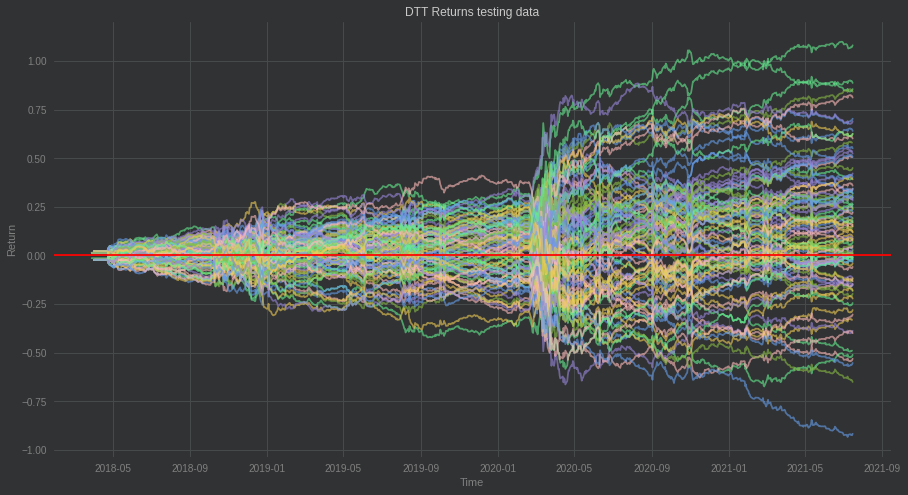

In [ ]:
#Organize well all the data
DTT_returns = pd.DataFrame(returns_val, index=[
    f"DTT_{i}" for i in range(len(returns_test))
]).transpose()

#Graph
plt.figure(figsize=(15,8))
plt.plot(DTT_returns.cumsum(axis=0), alpha=0.6)
plt.axhline(0, color="red")
plt.title("DTT Returns testing data")
plt.ylabel("Return")
plt.xlabel("Time")
plt.show()

Crear un criterio de decisión

In [ ]:
DTT_returns

,DTT_0,DTT_1,DTT_2,DTT_3,DTT_4,DTT_5,DTT_6,DTT_7,DTT_8,DTT_9,...,DTT_90,DTT_91,DTT_92,DTT_93,DTT_94,DTT_95,DTT_96,DTT_97,DTT_98,DTT_99
date,,,,,,,,,,,,,,,,,,,,,
2018-03-29,NaN,NaN,0.013770,NaN,NaN,0.013770,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-02,-0.022337,0.022337,-0.000000,-0.022337,-0.022337,-0.000000,-0.022337,0.022337,0.022337,-0.022337,...,-0.022337,-0.022337,-0.022337,-0.022337,-0.022337,-0.022337,-0.022337,-0.022337,-0.022337,0.022337
2018-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-12,0.003451,0.003451,0.003451,0.003451,-0.003451,0.003451,-0.003451,-0.003451,-0.003451,0.003451,...,0.003451,-0.003451,-0.003451,0.003451,-0.003451,0.003451,0.003451,0.003451,0.003451,-0.003451
2021-07-13,-0.003517,-0.003517,-0.003517,-0.003517,0.003517,-0.003517,0.003517,0.003517,0.003517,-0.003517,...,-0.003517,0.003517,-0.003517,-0.003517,-0.003517,0.003517,-0.003517,0.003517,-0.003517,0.003517
2021-07-14,0.001165,0.001165,0.001165,0.001165,-0.001165,0.001165,-0.001165,-0.001165,-0.001165,0.001165,...,0.001165,-0.001165,-0.001165,0.001165,0.001165,-0.001165,0.001165,-0.001165,0.001165,-0.001165


We fixed the problem of stochastic initialization with a criteria that filters the best DNNs

In [ ]:
#Create an empty Dataframe
dnns = DTT_returns.columns;

values = pd.DataFrame( index = ["Final_return(%)", "Esperanza(%)"] );

for i in dnns:
   Final_return = DTT_returns[i].cumsum().iloc[-1];
   Esperanza = DTT_returns[i].mean()*100;
   values[i] = Final_return*100, Esperanza*100;

best_models = list(values.transpose().sort_values(by="Esperanza(%)", ascending = False).index[0:9]);
values.transpose().sort_values(by="Esperanza(%)", ascending = False)

,Final_return(%),Esperanza(%)
DTT_97,108.148932,13.029992
DTT_13,88.784300,10.696904
DTT_7,85.628474,10.316684
DTT_28,84.273398,10.153421
DTT_83,81.242264,9.788225
...,...,...
DTT_31,-51.099726,-6.156594
DTT_11,-53.140503,-6.402470
DTT_60,-55.292473,-6.661744
DTT_94,-65.078130,-7.840739
